In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.signal, scipy.io.wavfile

In [89]:
# Load sound file
samp, snd = scipy.io.wavfile.read('Tetris0.wav')
snd = snd[:int(snd.shape[0]/2),0]

secs = len(snd)/float(samp) # Number of seconds in signal X
new_samp = 2205 #11025 #8000
old_samp = samp
samps = int(secs*new_samp)     # Number of samples to downsample
samp = new_samp
Y = scipy.signal.resample(snd, samps)
print snd.shape
scipy.io.wavfile.write('Tetris_test.wav', samp, snd)
print samp
#samp2, outsnd = scipy.io.wavfile.read('out.wav')

(661504,)
2205


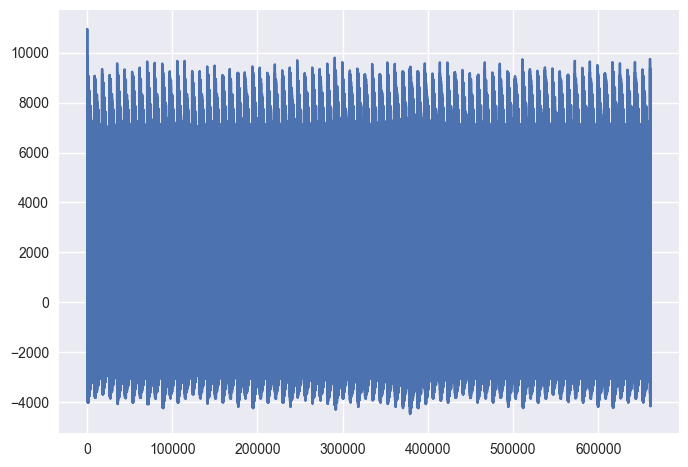

In [90]:
plt.plot(snd);
#plt.plot(10000*outsnd);

In [91]:
import IPython
IPython.display.Audio(data=snd, rate=samp*(old_samp/new_samp))

In [92]:
#samp_freq = 44.1e3 # Hz
#f, t, Sxx = scipy.signal.spectrogram(snd, samp_freq, 
#                                     mode='complex',
#                                    return_onesided=True)

In [93]:
# From 
import scipy, pylab

def stft(x, fs, framesz, hop):
    framesamp = int(framesz*fs)
    hopsamp = int(hop*fs)
    w = scipy.hanning(framesamp)
    X = scipy.array([scipy.fft(w*x[i:i+framesamp]) 
                     for i in range(0, len(x)-framesamp, hopsamp)])
    return X

def istft(X, fs, T, hop):
    x = scipy.zeros(T*fs)
    framesamp = X.shape[1]
    hopsamp = int(hop*fs)
    for n,i in enumerate(range(0, len(x)-framesamp, hopsamp)):
        x[i:i+framesamp] += scipy.real(scipy.ifft(X[n]))
    return x

def coerce_between(xs, min_x=0, max_x=255):
    old_min = np.min(xs)
    old_range = np.max(xs) - old_min  
    new_range = max_x - min_x  
    return (((xs - old_min) * new_range) / old_range) + min_x

(4008, 330)


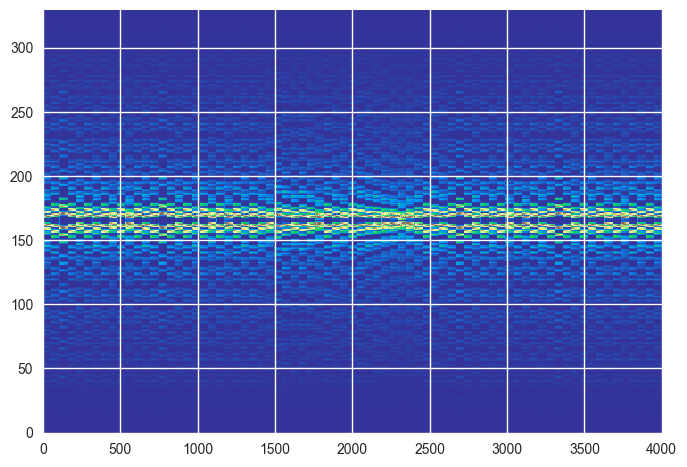

In [95]:
fs = samp       # sampled at [samp] kHz
T = 5           # lasting 20 seconds
framesz = 0.150  # with a frame size of 50 milliseconds
hop = 0.0750  # and hop size of 25 milliseconds.

fft = stft(snd, fs, framesz, hop)

def reshape_fft(fft):
    result = np.zeros_like(fft)
    nrows, ncols = result.shape
    result[:, :ncols/2] = fft[:, ncols/2:]
    result[:, ncols/2:] = fft[:, :ncols/2]
    return result

# reshape FFT to be zero-centered
fft = reshape_fft(fft)

print fft.shape
plt.imshow(scipy.absolute(fft.T), origin='lower', aspect='auto',
                 interpolation='nearest',cmap=plt.get_cmap('terrain'));

In [62]:
# map real values to 0-255
# map complex values to 0-255
def mag_phase(xs):
    return np.abs(xs), np.angle(xs)

def log_mag(mag, shift=1e-3):
    return np.log(mag + shift)

def invert_log(logmag, shift=1e-3):
    return np.exp(mag) - shift

def truncate_phase(phase, mag, cutoff=1e-2):
    new_phase = phase.copy()
    new_phase[mag <= cutoff] = 0
    return new_phase

def mag_phase_to_complex(mag, phase):
    return mag*np.exp(1j*phase)

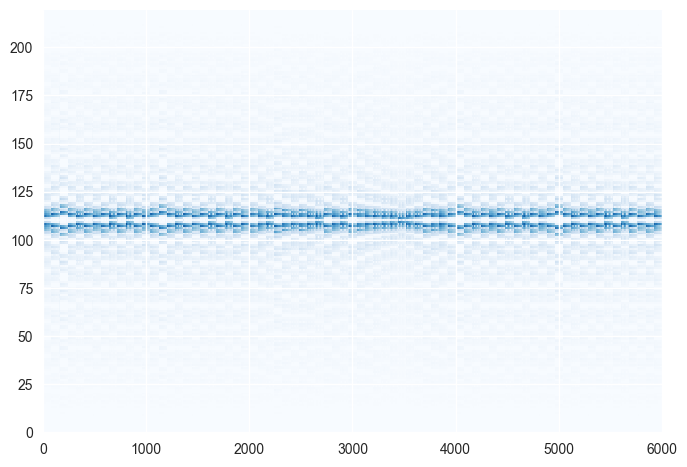

In [63]:
mag, phase = mag_phase(fft)
phase = phase + np.pi
phase = truncate_phase(phase, mag)
logmag = np.log(mag)
logmag = coerce_between(logmag, 0, 255)
#sns.distplot(np.hstack(logmag))
pixel_logmag = np.round(logmag)
# convert back
mag_ = np.exp(coerce_between(pixel_logmag, -6, 6))
phase_ = phase
fft_ = mag_phase_to_complex(mag_, phase_)
plt.imshow(np.abs(fft_.T), origin='lower', aspect='auto',
                 interpolation='nearest',cmap=plt.get_cmap('Blues'));

plt.imshow(np.abs(fft.T), origin='lower', aspect='auto',
                 interpolation='nearest',cmap=plt.get_cmap('Blues'));

In [86]:
from PIL import Image
def fft_to_rgb(fft):
    # assumes fft is complex
    nrows, ncols = fft.shape
    img_arr = np.zeros((nrows, ncols, 3), 
                       dtype=np.int32) # 3 layers for RGB
    # convert magnitude to 0-255
    mag, phase = mag_phase(fft)
    logmag = np.log(mag)
    logmag = coerce_between(logmag, 0, 255)
    #sns.distplot(np.hstack(logmag))
    pixel_logmag = np.round(logmag)
    
    phase = phase + np.pi # shift phase 0 to 2pi
    phase = truncate_phase(phase, mag)
    pixel_phase = np.round(coerce_between(phase, 0, 255))
    img_arr[:,:,0] = pixel_logmag
    img_arr[:,:,1] = pixel_phase
    return img_arr
    
img_arr = fft_to_rgb(fft)
im = Image.fromarray(img_arr, mode='RGB')
print im.size
im.save("fft.png")

(220, 6012)


In [81]:
type(img_arr)

numpy.ndarray

255.0
0.0


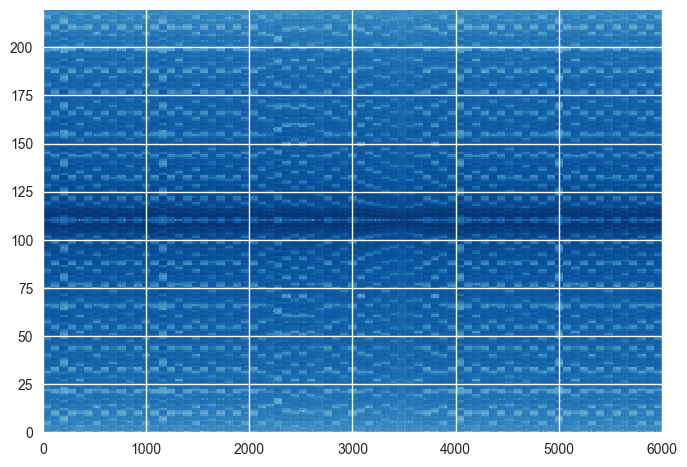

In [64]:
#plt.hist(logmag)
print np.max(logmag)
print np.min(logmag)
logmag = coerce_between(logmag, -7, 13)
pixel_mag = coerce_between(logmag, 0, 255)

plt.imshow(pixel_mag.T, origin='lower', aspect='auto',
                 interpolation='nearest',cmap=plt.get_cmap('Blues'));

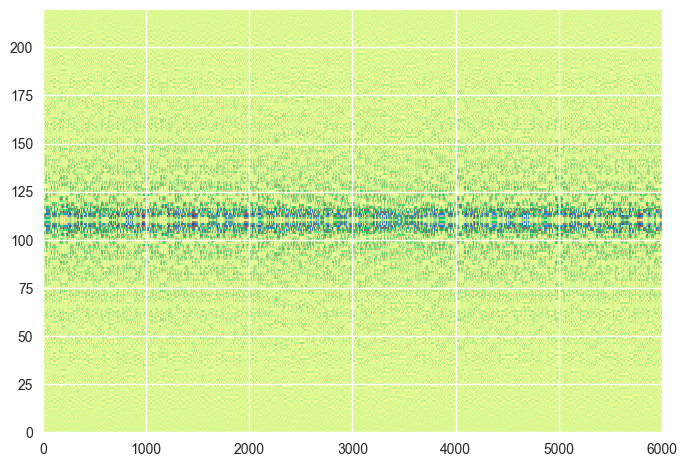

In [65]:
# convert from cos + i sin to mag/phase
mag, phase = mag_phase(fft)
mag = np.round(coerce_between(mag, 0, 255))
#phase = np.angle(fft) + np.pi
#phase = truncate_phase(phase, mag)

logmag = log_mag(mag)
#plt.imshow(logmag.T, origin='lower', aspect='auto',
#                 interpolation='nearest',cmap=plt.get_cmap('terrain'));
#plt.plot(np.real(fft[0,:]))

# test inverting
#mag_ = 
phase_ = phase
conv_ = mag_phase_to_complex(mag_, phase_)
plt.imshow(np.real(conv_.T), origin='lower', aspect='auto',
                 interpolation='nearest',cmap=plt.get_cmap('terrain'));

In [66]:
np.abs(conv_)
np.abs(fft)/np.max(np.abs(fft))

array([[  1.30108770e-09,   1.30108770e-09,   1.30108770e-09, ...,
          1.30108770e-09,   1.30108770e-09,   1.30108770e-09],
       [  1.36613672e-03,   1.28781861e-03,   1.15074227e-03, ...,
          8.33601629e-04,   1.15074227e-03,   1.28781861e-03],
       [  7.36901416e-04,   6.27467724e-04,   7.70227292e-04, ...,
          6.51168656e-04,   7.70227292e-04,   6.27467724e-04],
       ..., 
       [  4.90524309e-04,   7.34442620e-04,   1.03236531e-03, ...,
          1.33906195e-03,   1.03236531e-03,   7.34442620e-04],
       [  5.12015818e-04,   7.33127246e-04,   8.76081162e-04, ...,
          1.18509072e-03,   8.76081162e-04,   7.33127246e-04],
       [  4.96521621e-04,   7.42587522e-04,   7.13470573e-04, ...,
          1.08104844e-03,   7.13470573e-04,   7.42587522e-04]])

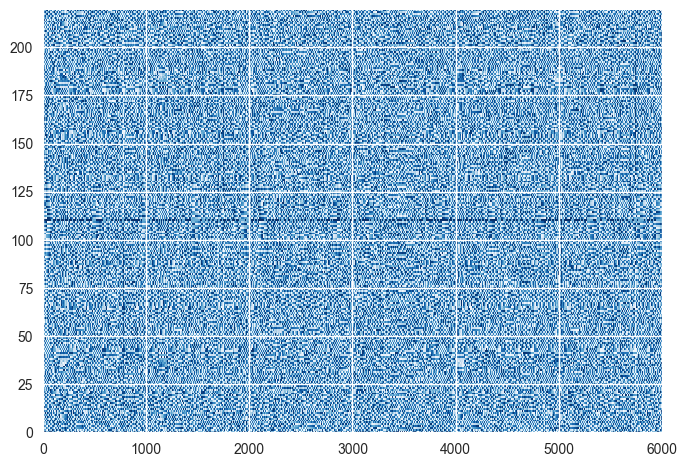

In [67]:
plt.imshow(phase.T, origin='lower', aspect='auto',
                 interpolation='nearest',cmap=plt.get_cmap('Blues'));

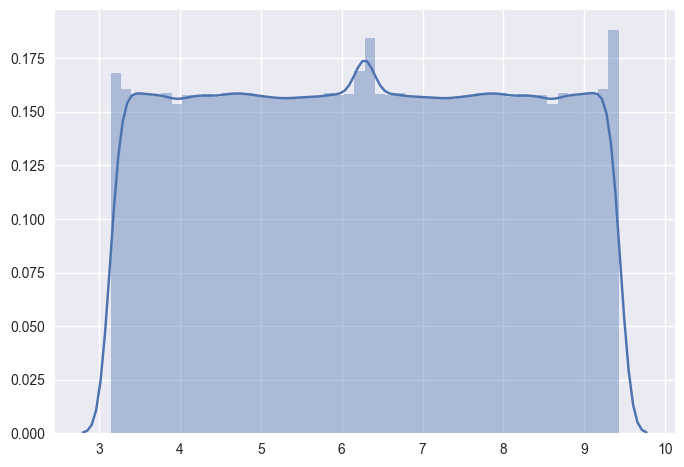

In [68]:
#sns.distplot(np.log(np.hstack(mag+0.0001)))
sns.distplot(np.hstack(phase+2*np.pi))

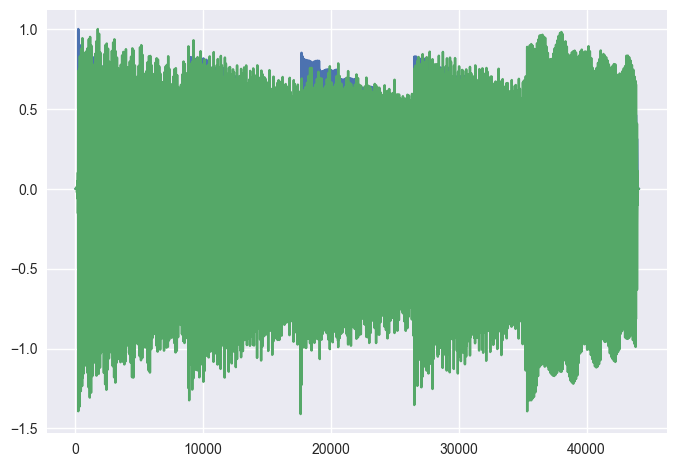

In [69]:
inv_fft = istft(reshape_fft(fft),
                fs, T, hop)
inv_fft_ = istft(reshape_fft(fft_),
                 fs, T, hop)

inv_fft /= max(inv_fft)
plt.plot(inv_fft);
inv_fft_ /= max(inv_fft_)
plt.plot(inv_fft_)

In [72]:
scipy.io.wavfile.write('out_.wav', samp*(old_samp/new_samp), inv_fft_)


In [ ]:
scipy.io.wavfile.write('out.wav', samp, inv)